In [1]:
import math
import pandas_datareader as web
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [2]:
df = web.DataReader('AAPL',data_source='yahoo',start = '2012-01-01',end='2019-12-17')

In [3]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.857235
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.130558
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.698215
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.238651
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.155792


In [4]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2003.000000,2003.000000,2003.000000,2003.000000,2.003000e+03,2003.000000
mean,127.194100,124.954538,126.079166,126.109797,5.960691e+07,119.067298
std,50.028310,49.234509,49.592770,49.679272,4.688887e+07,51.605990
min,57.085712,55.014286,55.424286,55.790001,1.136200e+07,49.010136
25%,86.649998,84.915001,85.766430,85.971428,2.760790e+07,75.110386
50%,114.019997,111.660004,112.820000,112.919998,4.369990e+07,105.228317
75%,165.939995,162.125000,163.845001,163.970001,7.482090e+07,158.339043
max,281.769989,278.799988,279.570007,280.410004,3.765300e+08,278.990875


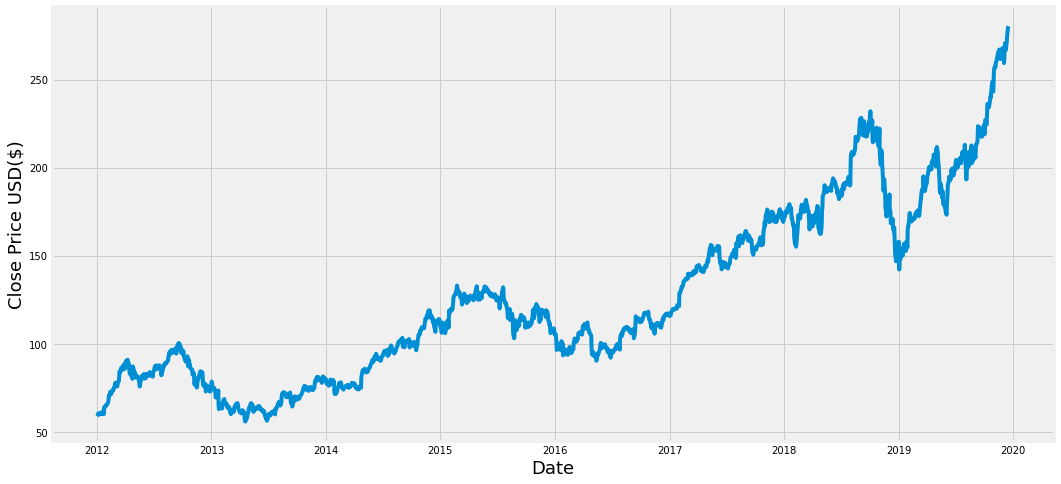

In [5]:
plt.figure(figsize=(16,8))
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
plt.show()

In [6]:
data = df.filter(['Close'])
dataset = data.values
training_len = math.ceil(len(dataset) * .8)
training_len

1603

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.01316509],
       [0.01457064],
       [0.01748985],
       ...,
       [0.97658263],
       [0.99755134],
       [1.        ]])

In [8]:
train_data = scaled_data[0 : training_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  if i<=60 :
    print(x_train)
    print(y_train)
    print()

[array([0.01316509, 0.01457064, 0.01748985, 0.02026915, 0.01984303,
       0.02080338, 0.02036454, 0.01962679, 0.01862193, 0.02173194,
       0.02453668, 0.02367172, 0.01893356, 0.02345548, 0.01900352,
       0.03569838, 0.03440731, 0.0360927 , 0.03973694, 0.04194384,
       0.0417594 , 0.0410789 , 0.04397903, 0.04670744, 0.04979839,
       0.05479095, 0.0652785 , 0.06543749, 0.07127594, 0.07563885,
       0.06814046, 0.07102789, 0.07097066, 0.07906688, 0.07791571,
       0.08004628, 0.08387497, 0.08600558, 0.09214292, 0.09661397,
       0.09790501, 0.09835659, 0.09071194, 0.08886753, 0.08914103,
       0.09632775, 0.09835024, 0.10269405, 0.11293358, 0.12659476,
       0.12403805, 0.1240444 , 0.13392141, 0.13701233, 0.13481179,
       0.13280207, 0.13070964, 0.13766105, 0.14243103, 0.14442805])]
[0.13949272033425864]



In [9]:
x_train, y_train = np.array(x_train),np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(1543, 60)
(1543,)


In [10]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [11]:
x_train.shape

(1543, 60, 1)

In [12]:
model = Sequential()
model.add(LSTM(50, return_sequences = True,input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [13]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, batch_size = 1, epochs = 1)

Epoch 1/1
1543/1543 [==============================] - 442s 287ms/step - loss: 7.8519e-04


In [14]:
test_data = scaled_data[training_len - 60: , :]
x_test = []
y_test = dataset[training_len : , :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [15]:
x_test = np.array(x_test)

In [16]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [17]:
x_test.shape

(400, 60, 1)

In [18]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [19]:
rmse = np.sqrt(np.mean(predictions - y_test)** 2)

In [20]:
rmse

4.157992630004883

In [21]:
train = data[:training_len]
valid = data[training_len:]
valid['predictions'] = predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


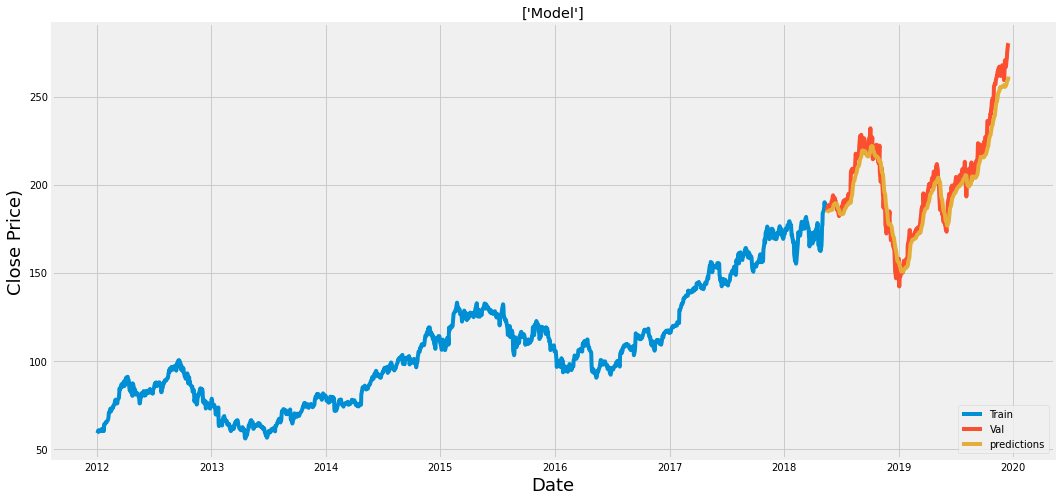

In [22]:
plt.figure(figsize=(16,8))
plt.title(['Model'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','predictions']])
plt.legend(['Train','Val','predictions'], loc = 'lower right')
plt.show()

In [23]:
valid

,Close,predictions
Date,,
2018-05-17,186.990005,184.172409
2018-05-18,186.309998,184.613022
2018-05-21,187.630005,184.796722
2018-05-22,187.160004,184.966507
2018-05-23,188.360001,185.058228
...,...,...
2019-12-11,270.769989,257.214905
2019-12-12,271.459991,257.959717
2019-12-13,275.149994,258.769073


In [29]:
train = web.DataReader('AAPL',data_source='yahoo',start='2012-01-01',end='2019-12-17')

In [30]:
new_df = train.filter(['Close'])

In [31]:
new_df.shape

(2003, 1)

In [32]:
last_60_days = new_df[-60:].values

In [33]:
last_60_days_scaled = scaler.transform(last_60_days)

In [35]:
X_test = []

In [36]:
X_test.append(last_60_days_scaled)

In [37]:
X_test = np.array(X_test)

In [38]:
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [39]:
X_test.shape

(1, 60, 1)

In [40]:
pred = model.predict(X_test)
pred = scaler.inverse_transform(pred)
print(pred)

[[263.14325]]


In [41]:
train = web.DataReader('AAPL',data_source='yahoo',start='2019-12-18',end='2019-12-18')

In [43]:
print(train['Close'])

Date
2019-12-18    279.73999
Name: Close, dtype: float64
